In [1]:
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
#import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from mrmr import mrmr_classif #feature selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS # feature selection

## DATA PREPARATION

In [2]:
df = pd.read_csv('database/RW_DATA_CUT-OFF_17.06.2021.csv')
data = df[['IT/CTIT', 'SurgeryY/N','AgeAtIO','Gender', 'SquamousNonSquamous', 'stadioAllaDiagnosi', 'fumoAllaDiagnosi','packYears', 'PDL1/1/149/50', 'LineaDiTerapiaICI', 'StageBasaleIO',  'BMIIoBasal', 'PS Baseline IO', 'TumorStage_IO', 'NodeStage_IO', 'MetastasisStage_IO', 'MLiverBasale', 'RTPreIT', 'LeukocytesIOBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale','LymphocytesAlBasale','NLR','LDHAlBasale', 'MBoneBasale','MPleuraBasale', 'MLinfonodiBasale', 'MSurreneBasale', 'MBrainBasale','DCR ']]
# vanno poi aggiunti altri outcomes (qua ho solo DCR)
data

FileNotFoundError: [Errno 2] No such file or directory: 'database/RW_DATA_CUT-OFF_17.06.2021.csv'

In [ ]:
print(data.groupby('DCR ').size())

# il dataset è bilanciato 

### RICORDALE!!
## -----------------------------

In [ ]:
# X_train.dtypes   # per vedere tipologie dato delle colonne
# print(data.groupby('nome_colonna').size())
# data.info(verbose=True) ----->   gives information about the data types,columns, null value counts, memory usage etc
# data.describe(include="all") -----> basic statistic details about the data (avg, std, quartili....)
# max_row=np.amax(matrix,axis=1)  ----->  per trovare massimo in una riga


## ------------------------------<br><br>SPLITTING TRAIN/TEST & IMPUTATION (fit sul training)

In [ ]:
# IMPUTING (USO SOLO TRAINING SET)
data.isnull().sum()

# PACKYEARS ne ha troppi, lo elimino!

data=data.drop(['packYears'],axis=1)

In [ ]:
for i in data['PDL1/1/149/50']:
    print(i)

In [ ]:
# FALLO ALL'INIZIO
y=data['DCR ']
data=data.iloc[:,:-1]
X_tr, X_t, y_train, y_test = train_test_split(data, y, stratify=y, random_state=84, test_size = 0.1)  #stratify=Y_all['DCR ']
X_tr

In [ ]:
# IMPUTATION

# define imputer
imputer = IterativeImputer()
# fit on the dataset
imputer.fit(X_tr)
# transform the dataset
X = imputer.transform(X_tr)
X1 = imputer.transform(X_t)
X_train = pd.DataFrame(X, columns=data.columns)
X_test = pd.DataFrame(X1, columns=data.columns)
X_train
# This Multivariate approach assigns imputed values by solving a linear regression problem performed on other features. 
# Each feature containing missing values is, in turn, considered the target of the regression model. The
# imputation algorithm is fitted on the training set and then applied to both training and test dataset

In [ ]:
X_train['PDL1/1/149/50']=round(X_train['PDL1/1/149/50']).astype('int64')
X_test['PDL1/1/149/50']=round(X_test['PDL1/1/149/50']).astype('int64')
for i in X_train['PDL1/1/149/50']:
    print(i)

## -----------------------------------------<br><br>ELIMINO ATTRIBUTI CON ELEVATA CORRELAZIONE (>0.8)

In [ ]:
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

cor_matrix = X_train.corr().abs()  #è un dataframe!!
print(cor_matrix)

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

# triu-->matrice triangolare superiore (k=1 indica a partire da quale diagonale, in questo caso la prima sopra la principale)
# astype-->converte dati nel formato specificato fra parentesi
# where-->se condizione è verificata, lascia il valore di partenza, sennò lo sostituisce con quello specificato (se non specifico 
#         nulla sostituisce con NaN)
# any-->se condizione è verificata da almeno un elemento della colonna allora ho true e aggiungo nome colonna al vettore "to_drop"
# WHERE e ANY sono di "pandas" in questo caso, non di "numpy"

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(to_drop)

# devo eliminare 'MetastasisStage_IO'
X_train=X_train.drop(X_train[to_drop],axis=1)
X_test=X_test.drop(X_test[to_drop],axis=1)

In [ ]:
X_train

In [3]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

## ----------------------------------------<br><br> DATA EXPLORATION (per num non serve a nulla)

In [4]:
X_tr.dtypes

NameError: name 'X_tr' is not defined

In [5]:
dat=X_tr.drop(X_tr[to_drop],axis=1)
categorical_features_indices = np.where(dat.dtypes == 'int64')[0]
#result = np.where(h == 'PDL1/1/149/50')
X_train_categorical=X_train.iloc[:,categorical_features_indices].astype(int)
X_train_categorical['PDL1/1/149/50']=X_train['PDL1/1/149/50']
X_test_categorical=X_test.iloc[:,categorical_features_indices].astype(int)
X_test_categorical['PDL1/1/149/50']=X_test['PDL1/1/149/50']
X_train_categorical

NameError: name 'X_tr' is not defined

In [6]:
dat=X_tr.drop(X_tr[to_drop],axis=1)
numerical_features_indices = np.where(dat.dtypes == 'float64')[0]
X_train_numerical=X_train.iloc[:,numerical_features_indices]
X_train_numerical=X_train_numerical.drop(['PDL1/1/149/50'],axis=1)
X_test_numerical=X_test.iloc[:,numerical_features_indices]
X_test_numerical=X_test_numerical.drop(['PDL1/1/149/50'],axis=1)
X_train_numerical

NameError: name 'X_tr' is not defined

array([[<AxesSubplot:title={'center':'AgeAtIO'}>,
        <AxesSubplot:title={'center':'BMIIoBasal'}>,
        <AxesSubplot:title={'center':'LeukocytesIOBasal'}>,
        <AxesSubplot:title={'center':'NeutrophylsiAlBasale'}>],
       [<AxesSubplot:title={'center':'MonocytesalBasale'}>,
        <AxesSubplot:title={'center':'LymphocytesAlBasale'}>,
        <AxesSubplot:title={'center':'NLR'}>,
        <AxesSubplot:title={'center':'LDHAlBasale'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

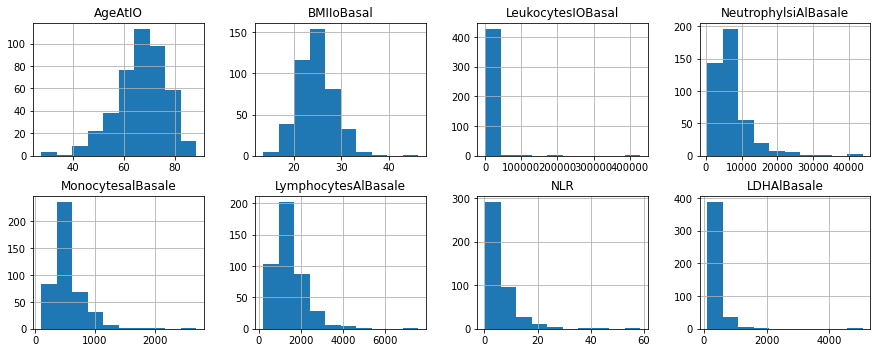

In [16]:
X=X_train_numerical


X.hist(layout=(4,4), figsize=(15,12))


# età è praticamente uguale, anche genere, idem squamoso, non squamoso, stadio alla diagnosi, BMI basale, M_surrene, M_brain
# outliers in LDHA e Leucociti

#leucociti, NLR e LDHA potrebbero avere outlier o essere power lwa distribution

In [17]:
neg_value=np.where(X['LeukocytesIOBasal']>0)[0]
X=X.iloc[neg_value,:]
print(X.shape)

(431, 8)


array([[<AxesSubplot:title={'center':'logLeuko'}>,
        <AxesSubplot:title={'center':'LeukocytesIOBasal'}>,
        <AxesSubplot:title={'center':'logNLR'}>,
        <AxesSubplot:title={'center':'NLR'}>],
       [<AxesSubplot:title={'center':'logLDHA'}>,
        <AxesSubplot:title={'center':'LDHAlBasale'}>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

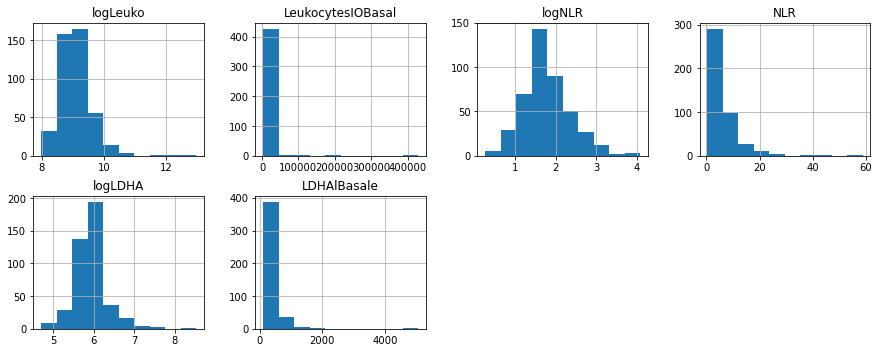

In [18]:
import math
X['logLeuko']=X['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X['logNLR']=X['NLR'].apply(lambda x: math.log(x+1))
X['logLDHA']=X['LDHAlBasale'].apply(lambda x: math.log(x+1))

X[['logLeuko','LeukocytesIOBasal','logNLR','NLR','logLDHA','LDHAlBasale']].hist(layout=(4,4), figsize=(15,12))


# posso tenere logNLR e logLDHA
# di leukocytes posso rimuovere outliers (o anche mantenere log)

In [19]:
m=np.quantile(X['LeukocytesIOBasal'],0.99)
leuko_99=np.where(X['LeukocytesIOBasal']<=m)[0]
X=X.iloc[leuko_99,:]

In [20]:
#X=X.drop(['LDHAlBasale','NLR','logLeuko'],axis=1)
X=X.drop(['LDHAlBasale','NLR','LeukocytesIOBasal'],axis=1)
X

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA
0,73.583333,23.180000,3900.0,400.0,1100.0,8.627123,1.514128,5.420535
1,78.000000,26.000000,4500.0,300.0,700.0,8.648397,2.005334,6.228511
2,67.750000,24.167162,3200.0,300.0,1000.0,8.478660,1.435085,5.978149
3,73.166667,24.767566,8800.0,700.0,900.0,9.269646,2.377486,5.730100
4,49.250000,25.390625,11900.0,400.0,600.0,9.480444,3.036554,6.167516
...,...,...,...,...,...,...,...,...
427,79.416667,28.934069,4400.0,300.0,800.0,8.664060,1.871802,5.686975
428,81.416667,27.471384,3700.0,400.0,1500.0,8.703009,1.243194,5.717028
429,50.500000,31.462672,10400.0,800.0,1800.0,9.530320,1.913649,6.234411
430,64.916667,22.790358,13500.0,900.0,1600.0,9.705707,2.244691,5.749393


In [21]:
h=np.array(X.index)
X_train_numerical=X
X_train_categorical=X_train_categorical.iloc[h,:]
y_train=y_train.iloc[h]

In [22]:
X_test_numerical['logLeuko']=X_test_numerical['LeukocytesIOBasal'].apply(lambda x: math.log(x+1))
X_test_numerical['logNLR']=X_test_numerical['NLR'].apply(lambda x: math.log(x+1))
X_test_numerical['logLDHA']=X_test_numerical['LDHAlBasale'].apply(lambda x: math.log(x+1))
X_test_numerical=X_test_numerical.drop(['NLR','LDHAlBasale','LeukocytesIOBasal'],axis=1)
X_test_numerical.columns

Index(['AgeAtIO', 'BMIIoBasal', 'NeutrophylsiAlBasale', 'MonocytesalBasale',
       'LymphocytesAlBasale', 'logLeuko', 'logNLR', 'logLDHA'],
      dtype='object')

## --------------------------<br><br> NORMALIZATION

In [23]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_numerical))  # scaling viene fatto sul training set
X_train_scaled.columns=X_train_numerical.columns
X_train_categorical.index=X_train_scaled.index

X_test_scaled = pd.DataFrame(scaler.transform(X_test_numerical))
X_test_scaled.columns=X_test_numerical.columns
X_test_categorical.index=X_test_scaled.index

In [24]:
X_train=pd.concat([X_train_scaled,X_train_categorical],axis=1)
X_test=pd.concat([X_test_scaled,X_test_categorical],axis=1)
X_train

,AgeAtIO,BMIIoBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,logLeuko,logNLR,logLDHA,IT/CTIT,SurgeryY/N,...,TumorStage_IO,NodeStage_IO,MLiverBasale,RTPreIT,MBoneBasale,MPleuraBasale,MLinfonodiBasale,MSurreneBasale,MBrainBasale,PDL1/1/149/50
0,0.676071,-0.391388,-0.715090,-0.543922,-0.479263,-0.989556,-0.450157,-1.248041,1,0,...,4,3,0,0,0,0,0,1,0,3
1,1.118887,0.343912,-0.575579,-0.926448,-1.005235,-0.941014,0.410223,0.692662,2,0,...,3,3,0,0,1,0,1,0,0,2
2,0.091219,-0.133991,-0.877853,-0.926448,-0.610756,-1.328315,-0.588607,0.091311,1,0,...,4,3,0,1,0,0,0,0,1,2
3,0.634296,0.022561,0.424250,0.603657,-0.742249,0.476541,1.062074,-0.504487,2,0,...,4,2,1,0,0,0,0,0,0,2
4,-1.763597,0.185021,1.145057,-0.543922,-1.136727,0.957534,2.216475,0.546158,1,0,...,0,0,1,1,1,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1.260923,1.108955,-0.598831,-0.926448,-0.873742,-0.905273,0.176334,-0.608069,1,1,...,4,0,0,1,0,0,0,0,0,2
422,1.461443,0.727567,-0.761593,-0.543922,0.046708,-0.816402,-0.924717,-0.535886,1,0,...,4,3,0,0,0,0,0,0,0,1
423,-1.638272,1.768274,0.796279,0.986183,0.441187,1.071341,0.249632,0.706833,1,0,...,4,2,0,0,0,0,0,0,0,1
424,-0.192852,-0.492985,1.517086,1.368710,0.178201,1.471535,0.829474,-0.458146,1,0,...,3,3,0,0,0,0,0,0,0,3


In [25]:
y_train.index=X_train.index
y_test.index=X_test.index
y_train

0      0
1      1
2      0
3      0
4      0
      ..
421    1
422    0
423    0
424    0
425    1
Name: DCR , Length: 426, dtype: int64

## --------------------------<br><br> FEATURE SELECTION 

In [27]:
#X_train=pd.concat([X_train_numerical,X_train_categorical],axis=1)
#X_test=pd.concat([X_test_numerical,X_test_categorical],axis=1)

In [28]:
model=[XGBClassifier(), RandomForestClassifier(), LogisticRegression()]
model_names=['XGBoost', 'Random Forest', 'Logistic Regression']
cv = StratifiedKFold(10)
#cv=LeaveOneOut()

### Recursive Feature Elimination

In [162]:
score=[]
scores=[]
n_feat=[]
ranking=[]
for i in range(0,len(model)):
    rfecv = RFECV(
        estimator=model[i],
        step=1,
        cv=cv,
        scoring="f1",
        min_features_to_select=1,
        n_jobs=-1,
    )
    
    rfecv.fit(X_train, y_train)

    score.append(rfecv.cv_results_)
    scores.append(max(score[i]['mean_test_score']))
    n_feat.append(rfecv.n_features_)

    
    print(model_names[i]+'\n')
    print("Number of features: {n}".format(n=n_feat[i]))
    print("Score: {s}".format(s=scores[i]))
    print(rfecv.ranking_)
    ranking.append(rfecv.ranking_)
    print('----------------\n')
    
print('The best is {m}'.format(m=model_names[scores.index(max(scores))]))

# XG e LR son sempre gli stessi, perché RF cambia??
# di media RF è sempre meglio (>0.72), XGB meglio di LR (con cv=10)


XGBoost

Number of features: 16
Score: 0.7042107030766327
[ 1  5  1  1  4  1  1  1  1  1  8  1  1  2  1  3  1  6  1  1 10  1 11 12
  9  7  1]
----------------

Random Forest

Number of features: 16
Score: 0.7202368987346067
[ 1  1  1  1  1  1  1  1  1  9  4  5  1  1  1  2  1  1  1  3  6  7  8 12
 11 10  1]
----------------

Logistic Regression

Number of features: 4
Score: 0.7145431209364772
[ 9 23 12 17 11 16  1  3  1 10 21  2 15 20  8  1  4 24 18  7  5 22 14  6
 19 13  1]
----------------

The best is Random Forest


In [171]:
main_feat=np.where(ranking[0]==1)[0]
X_tr=X_train.iloc[:,main_feat]
X_t=X_test.iloc[:,main_feat]
X_tr

#main_feat

,AgeAtIO,NeutrophylsiAlBasale,MonocytesalBasale,logLeuko,logNLR,logLDHA,IT/CTIT,SurgeryY/N,SquamousNonSquamous,stadioAllaDiagnosi,LineaDiTerapiaICI,PS Baseline IO,NodeStage_IO,MLiverBasale,MBoneBasale,PDL1/1/149/50
0,0.676071,-0.715090,-0.543922,-0.989556,-0.450157,-1.248041,1,0,2,4,1,0,3,0,0,3
1,1.118887,-0.575579,-0.926448,-0.941014,0.410223,0.692662,2,0,1,4,1,2,3,0,1,2
2,0.091219,-0.877853,-0.926448,-1.328315,-0.588607,0.091311,1,0,1,4,3,0,3,0,0,2
3,0.634296,0.424250,0.603657,0.476541,1.062074,-0.504487,2,0,1,4,1,1,2,1,0,2
4,-1.763597,1.145057,-0.543922,0.957534,2.216475,0.546158,1,0,1,4,4,0,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,1.260923,-0.598831,-0.926448,-0.905273,0.176334,-0.608069,1,1,2,1,2,0,0,0,0,2
422,1.461443,-0.761593,-0.543922,-0.816402,-0.924717,-0.535886,1,0,1,4,1,0,3,0,0,1
423,-1.638272,0.796279,0.986183,1.071341,0.249632,0.706833,1,0,1,4,4,1,2,0,0,1
424,-0.192852,1.517086,1.368710,1.471535,0.829474,-0.458146,1,0,1,4,1,2,3,0,0,3


### MRMR

In [64]:
selected_features=[]
vect_feat=np.arange(2,X_train.shape[1],2)
vect_feat=np.append(vect_feat,27)
for i in vect_feat:
    features = mrmr_classif(X=X_train, y=y_train, K=i)
    selected_features.append(features)


100%|██████████| 27/27 [00:04<00:00,  6.38it/s]


In [72]:
#X_tr=X_train.loc[:,selected_features]
#X_t=X_test.loc[:,selected_features]

#X_tr

### Exhaustive Feature Selection

In [ ]:
score=[]
scores=[]
n_feat=[]
ranking=[]

for i in range(0,len(model)):

    efs = EFS(model[i], 
           min_features=5,
           max_features=20,
           scoring='f1',
           print_progress=True,
           cv=cv)
   
    
    efs.fit(X_train, y_train)

    score.append(efs.best_score_)
    n_feat.append(efs.best_feature_names_)
    
    print(model_names[i]+'\n')
    print('Best F1 score: %.2f' % efs.best_score_)
    print('Best subset (indices):', efs.best_idx_)
    print('Best subset (corresponding names):', efs.best_feature_names_)


### AIC score

In [144]:
X_tra=X_train

In [220]:
feats=np.arange(1,X_tra.shape[1]+1)
AIC_global=np.zeros((len(model),X_tra.shape[1]))

y=y_train

X_sel_list=[]

for i in range(0,len(model)):
    X_sel=pd.DataFrame()
    idx=X_tra.columns
    for n in range(0, len(feats)):
        AIC=[]
        k=0
        for j in idx:
            X=pd.concat([X_sel,pd.DataFrame(X_tra.loc[:,j])],axis=1)
            pred = cross_val_predict(model[i], X, y, cv=5,method='predict_proba')
            # prendo solo pred[:,1] perché mi interessa solo probabilità
            loglike=np.log(pow(pred[:,1],y_train)*pow(1-pred[:,1],1-y_train))
            inf=np.where(loglike==-math.inf)[0]
            loglike[inf]=0
            loglike=sum(loglike)
            AIC.append(2*n-2*loglike)
            if(AIC[k]==min(AIC)):
                main_f=j
            k=k+1
        
        AIC_global[i,n]=min(AIC)
        idx=np.delete(idx,np.where(idx==main_f))
        X_sel=pd.concat([X_sel, pd.DataFrame(X_tra.loc[:,main_f])],axis=1)
        
    X_sel_list.append(X_sel)

            
           

In [145]:
#AIC_global

In [233]:
X_sel_list[2]

,logNLR,AgeAtIO,LeukocytesIOBasal,NeutrophylsiAlBasale,MonocytesalBasale,LymphocytesAlBasale,BMIIoBasal
0,-0.450157,0.676071,-0.823461,-0.715090,-0.543922,-0.479263,-0.391388
1,0.410223,1.118887,-0.798473,-0.575579,-0.926448,-1.005235,0.343912
2,-0.588607,0.091219,-0.983805,-0.877853,-0.926448,-0.610756,-0.133991
3,1.062074,0.634296,0.223979,0.424250,0.603657,-0.742249,0.022561
4,2.216475,-1.763597,0.742494,1.145057,-0.543922,-1.136727,0.185021
...,...,...,...,...,...,...,...
421,0.176334,1.260923,-0.779731,-0.598831,-0.926448,-0.873742,1.108955
422,-0.924717,1.461443,-0.731836,-0.761593,-0.543922,0.046708,0.727567
423,0.249632,-1.638272,0.882013,0.796279,0.986183,0.441187,1.768274
424,0.829474,-0.192852,1.431763,1.517086,1.368710,0.178201,-0.492985


## -------------------------------------------------<br><br>CLASSIFICATION

In [34]:
# PER NON FARE FEATURE SELECTION
#X_tr=X_train
#X_t=X_test

In [141]:
#classifier=LogisticRegression()
#classifier = MLPClassifier()
#classifier= RandomForestClassifier()
classifier=XGBClassifier()
#classifier=CatBoostClassifier()
#parameters = {"C":[1e-5,1e-2,1,10],"penalty":['l2'], "max_iter":[1000,2000]}
#parameters = {"hidden_layer_sizes":[(5,3,2),(5,3),(3)],  "max_iter": [5000], "alpha": [0.1,1,10]}
#parameters = {'n_estimators' : [300, 400], 'criterion' : ['entropy', 'gini'], 'max_depth' : [2,3],  'min_samples_split' : [4,5],'min_samples_leaf' : [4,5]}
parameters={'n_estimators': [400,500], 'max_depth':[2,4],'learning_rate':[0.01,0.1],'gamma':[0.5,0.1],'eta':[0.3]}
#parameters={'learning_rate': [0.001,0.003, 0.03], 'depth': [4,6,7], 'l2_leaf_reg': [7,9,11,13]}


gs = GridSearchCV(classifier, parameters, cv=10, scoring = 'f1', n_jobs=-1, refit=True, return_train_score=True)#verbose=50

# n_jobs=-1 ----> uso tutti i processori

F1_train=[]
acc_train=[]
F1_test=[]
acc_test=[]
AUC=[]
best_models=[]

for i in selected_features:
    X_tr=X_train.loc[:,i]
    X_t=X_test.loc[:,i]
    gs1=gs.fit(X_tr,y_train)
    best_model=gs1.best_estimator_
    best_models.append(best_model)
    
    y_pred=best_model.predict(X_t)
    y_pred_train=best_model.predict(X_tr)
    
    F1_train.append(metrics.f1_score(y_train, y_pred_train))
    F1_test.append(metrics.f1_score(y_test, y_pred))
    acc_train.append(metrics.accuracy_score(y_train, y_pred_train))
    acc_test.append(metrics.accuracy_score(y_test, y_pred))
                    
    y_probs = best_model.predict_proba(X_t)
    AUC.append(metrics.roc_auc_score(y_test, y_probs[:,1]))


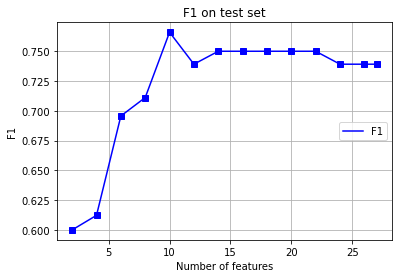

Best F1: 0.7659574468085107 
-------------------
Number of features: 10
-------------------
Features: 
['IT/CTIT', 'MBoneBasale', 'MonocytesalBasale', 'logLDHA', 'logNLR', 'LineaDiTerapiaICI', 'PS Baseline IO', 'MLiverBasale', 'PDL1/1/149/50', 'StageBasaleIO']


In [129]:
plt.plot(vect_feat, F1_test,'b-',label='F1')
plt.plot(vect_feat, F1_test, 'bs')
plt.xlabel('Number of features')
plt.ylabel('F1')
plt.title('F1 on test set')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

print("Best F1: {f1} ".format(f1=max(F1_test)))
max_ind=np.where(F1_test==max(F1_test))[0]
print("-------------------\nNumber of features: {n}".format(n=vect_feat[h[0]]))
print("-------------------\nFeatures: \n{n}".format(n=selected_features[h[0]]))

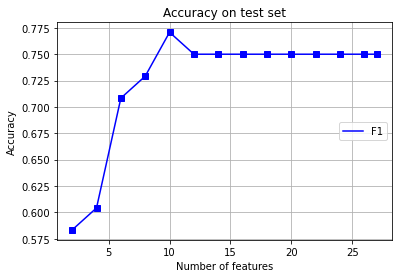

Accuracy(10 features): 0.7708333333333334


In [136]:
plt.plot(vect_feat, acc_test,'b-',label='F1')
plt.plot(vect_feat, acc_test, 'bs')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy on test set')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

# with XGBoost I have best accuracy and best F1 with 10 features
print("Accuracy({n} features): {a}".format(n=vect_feat[h[0]],a=acc_test[h[0]]))

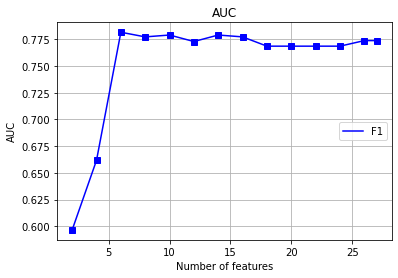

AUC(10 features): 0.7791304347826087


In [137]:
plt.plot(vect_feat, AUC,'b-',label='F1')
plt.plot(vect_feat, AUC, 'bs')
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.title('AUC')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

print("AUC({n} features): {a}".format(n=vect_feat[h[0]],a=AUC[h[0]]))


              precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.82      0.72      0.77        25

    accuracy                           0.77        48
   macro avg       0.77      0.77      0.77        48
weighted avg       0.78      0.77      0.77        48



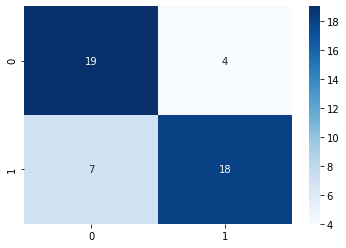

In [142]:
#CLASSIFICATION REPORT FOR THE BEST CLASSIFIER
X_tr=X_train.loc[:,selected_features[h[0]]]
X_t=X_test.loc[:,selected_features[h[0]]]

gs1=gs.fit(X_tr,y_train)
best_model=gs1.best_estimator_
y_pred=best_model.predict(X_t)
y_pred_train=best_model.predict(X_tr)
y_probs = best_model.predict_proba(X_t)

print()
print(classification_report(y_test, y_pred))

# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

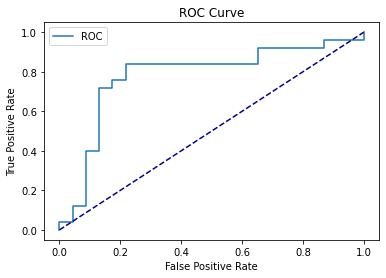

AUC: 0.78


In [143]:
fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

### Classification 

## Possibili strategie feature selection

### Analisi univariata

<b>Rimuovere variabili a bassa varianza (<u>vedi es. 09_5_Data_Exploration</u>):</b> fare attenzione perché potrebbe comunque trattarsi di una variabile che ha intrinsecamente una bassa variabilità e dove anche una piccola variazione è rilevante

<b>Guardo distribuzioni univariate (<u>vedi es. 09_5_Data_Exploration</u>):</b> confronto distribuzioni fra 0 e 1 del target, se sono molto sovrapposte posso eliminare (sia boxplot che istogrammi)

<b>Test statistici (<u>vedi es. 09_5_Data_Exploration</u>):</b>  test d'ipotesi chi-quadro ed F
